In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, cohen_kappa_score
import time
from scipy.stats import linregress

In [2]:
# Gestion GPU pour pas bugger
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Flatten, Dense, GlobalMaxPool1D, Reshape, AveragePooling1D
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers, initializers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow import reduce_sum
import tensorflow_addons as tfa
# Construction MCNN
########################### First level : Transformation Stage ###########################
# Original
class Original():
    def __init__(self, input1, window_size=10, channels_num=10, pool_size=10):
        # Conv + pooling (Local Convolution Stage)
        tf.random.set_seed(0)
        self.output = Conv1D(channels_num, window_size, 
                             activation='relu', 
                             kernel_initializer=RandomNormal(mean=1 / window_size, stddev=0.005, seed=44),
                             #kernel_regularizer="L1L2",
                             bias_initializer='zeros',
                             name='Original') (input1)
        self.output = MaxPool1D(pool_size = (pool_size)) (self.output)
        #print("Output size after maxpool - Origianl")
        #print(self.output.shape)

# Smoothing with smoothing_freq
class Smoothing_single():
    def __init__(self, input1, smoothing_freq, window_size=10, channels_num=10, pool_size=10):
        length = input1.shape[1]
        # Smooth
        # ce que utilise dans le rapport : convoluer avec [1, 1, 1, ..., 1]
#        self.output = tf.nn.conv1d(input1, 
#                                   tf.ones([smoothing_freq, input1.shape[2], input1.shape[2]], dtype=tf.float32), 
#                                   stride=1, padding='SAME', data_format='NWC', 
#                                   dilations=None, name="Smoothingfreq{}".format(smoothing_freq))
        # ça marche mieux en prenant AveragePooling1D
        self.output = AveragePooling1D(pool_size=smoothing_freq, padding='same', data_format='channels_last') (input1)
        
        # On augmente la taille pour avoir tous la même taille à la sortie.
        paddings = tf.constant([[0, 0], [0, length - self.output.shape[1]], [0, 0]])
        self.output = tf.pad(self.output, paddings=paddings, mode='CONSTANT', constant_values=0.)

        # Conv + pooling (Local Convolution Stage)
        tf.random.set_seed(0)
        self.output = Conv1D(channels_num, window_size,
                             kernel_initializer=RandomNormal(mean=1 / window_size, stddev=0.005, seed=44),
                             #kernel_regularizer="L1L2",
                             bias_initializer='zeros',
                             activation='relu') (self.output)
        self.output = MaxPool1D(pool_size = (pool_size)) (self.output)
        #print("Output size after maxpool - Smoothing_single freq{}".format(smoothing_freq))
        #print(self.output.shape)

class Smoothing():
    def __init__(self, input1, smoothing_freq_max, step, window_size=10, channels_num=10, pool_size=10):
        self.output = tf.concat([Smoothing_single(input1, i, window_size, channels_num, pool_size).output 
                                 for i in range(5, smoothing_freq_max, step)], axis=2)
        
# Down-sampling with down_freq
class DownSampling_single():
    def __init__(self, input1, down_freq, window_size=10, channels_num=10, pool_size=10):
        length = input1.shape[1]

        # Down sampling
        self.output = tf.slice(input1, begin=[0, 0, 0], 
                               size=[-1, length//down_freq, -1], name='DownSamplingfreq{}'.format(down_freq))
        
        paddings = tf.constant([[0, 0], [0, length - self.output.shape[1]], [0, 0]])
        self.output = tf.pad(self.output, paddings=paddings, mode='CONSTANT', constant_values=0.)
        
        # Conv + pooling (Local Convolution Stage)
        tf.random.set_seed(0)
        self.output = Conv1D(channels_num, window_size, 
                             kernel_initializer=RandomNormal(mean=1 / window_size, stddev=0.005, seed=44),
                             #kernel_regularizer="L1L2",
                             bias_initializer='zeros',
                             activation='relu') (self.output)
        self.output = MaxPool1D(pool_size = (pool_size)) (self.output)
        #print("Output size after maxpool - DownSampling freq{}".format(down_freq))
        #print(self.output.shape)

class DownSampling():
    def __init__(self, input1, down_freq_max, step, window_size=10, channels_num=10, pool_size=10):
        self.output = tf.concat([DownSampling_single(input1, i, window_size, channels_num, pool_size).output
                                for i in range(2, down_freq_max, step)], axis=2)
        print("Length after the first level with Down Sampling, Smoothing and Original : {}".format(self.output.shape[1]))

########################### Second level : Concatenation Stage ###########################
class Final_model():
    def __init__(self, length, leng_cha, smoothing_freq_max, down_freq_max, 
                 conv_channel, conv_windows, step_smoothing, step_down,
                 window_ori, channels_ori, pool_ori,
                 window_sm, channels_sm, pool_sm,
                 window_dn, channels_dn, pool_dn,
                 nb_dense, class_nb):

        input1 = Input(shape=(length, leng_cha), name="Input")
        orig = Original(input1, window_size=window_ori, channels_num=channels_ori, pool_size=pool_ori)
        smoothing = Smoothing(input1, smoothing_freq_max, step_smoothing, window_sm, channels_sm, pool_sm)
        down_sampling = DownSampling(input1, down_freq_max, step_down, window_dn, channels_dn, pool_dn)

        # Concatenation
        commun = tf.concat([orig.output, smoothing.output, down_sampling.output], axis=2, name="Concatenation")
        # Conv + Pooling
        tf.random.set_seed(0)
        commun = Conv1D(conv_channel, conv_windows, 
                        kernel_initializer=RandomNormal(mean=1 / conv_windows, stddev=0.005, seed=44),
                        #kernel_regularizer="L1L2",
                        bias_initializer='zeros',
                        activation='relu') (commun)
        commun = Flatten() (commun)
        print("Number of characteristics after the Conv1D commun : {}".format(commun.shape[1]))
        commun = Dense(nb_dense, kernel_initializer=RandomNormal(mean= 0, stddev=0.05, seed=44),
                       bias_initializer='zeros', activation='relu') (commun)
        print("Number of characteristics before the output : {}".format(commun.shape[1]))
        
        if class_nb == 7:
            nb_dense = 2
        elif class_nb == 3:
            nb_dense = 3
        else:
            nb_dense = 1
        # We use sigmoid because the reponse is relatif linear between 0 and 1
        # and 0 and 1 for the values at the both sides.
        # Result
        res = Dense(nb_dense, kernel_initializer=RandomNormal(mean= 0, stddev=0.05, seed=44),
                    bias_initializer='zeros', activation='sigmoid') (commun)

        self.model = Model(inputs=input1, outputs=res)

In [5]:
###################### Function which prints the graph for analysis ######################
def labelize(label):
    res = np.zeros(len(label))
    for j in range(len(label)):
        i = label[j]
        if i == 0:
            res[j] = 0
        elif i == 0.5:
            res[j] = 1
        else:
            res[j] = 2
    return res

def print_confusion(confusion, labels, sommes):
    print("Prediction :\t", end="")
    for i in labels:
        print(i, "\t", end="")
    print()
    print("\tReal :" + "\t" * (len(labels) +1) + "Total")
    for i in range(len(labels)):
        print("\t", labels[i], "\t", end="")
        for j in confusion[i]:
            print("%1.2f" %j, "\t", end="")
        print(sommes[0][i])
    print("\t" + "Total:" +"\t", end="")
    for i in range(len(labels)):
        print(sommes[1][i], end="\t")
    print(np.sum(sommes[1]))
    

def analyse(X_test, y_test, class_nb, v_a, history=None, model=None):
    ############# Plot training & validation loss values #############
    if history is not None:
        print("Loss:")
        plt.ylim(0, max(history.history['val_loss'][5], 3))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper right')
        plt.show()
        
    if class_nb == 7:
        if v_a == 0:
            val_arou = "valence"
        else:
            val_arou = "arousal"
        print("Analyse pour {}".format(val_arou))

    ############# Visualisation resultat #############
    if class_nb == 7 or class_nb == 2:
        print("Prediction:")
        
    if class_nb == 7:
        prediction = np.squeeze(model.predict(X_test)[:, v_a]) * 6 + 1
        y_test = y_test[:, v_a] * 6 + 1
    elif class_nb == 2:
        prediction = np.squeeze(model.predict(X_test))
    elif class_nb == 3:
        prediction = []
        for y in model.predict(X_test):
            if y[0] > y[1] and y[0] > y[2]:
                prediction.append(0)
            elif y[1] > y[0] and y[1] > y[2]:
                prediction.append(1)
            else:
                prediction.append(2)
        prediction = np.array(prediction)
        y_test_loc = []
        for y in y_test:
            if y[0] == 1:
                y_test_loc.append(0)
            elif y[1] == 1:
                y_test_loc.append(1)
            else:
                y_test_loc.append(2)
        y_test = np.array(y_test_loc)

    err = prediction - y_test

    # The line that we want our points on it
    if class_nb == 7:
        x = np.linspace(1, 7, 1000)
        plt.plot(x, x)
    elif class_nb == 2:
        x = np.linspace(0, 1, 1000)
        plt.plot(x, x)
    else:
        pass
    if class_nb == 7 or class_nb == 2:
        for i in range(len(prediction)):
            plt.scatter(prediction[i], y_test[i])
        plt.xlabel("Predictions")
        plt.ylabel("True values")
        plt.show()

    ############# Error #############
    if class_nb == 2 or class_nb == 7:
        print("Error histogram:")
        weights = np.ones(len(err)) / len(err)
        plt.hist(err, weights=weights)
        plt.show()

    ############# Confusion matrix #############
    # Normalement on peut changer les coefficients en regardant le comportement du modèle sur les train set.
    # Mais on a pas assez de temps...       
    if class_nb == 2:
        print("Confusion matrix (same row = same True values):")
        prediction[prediction <= 0.5] = 0
        prediction[(prediction > 0.5)] = 1
        print("Labels = ", [0, 1])
        confusion = confusion_matrix(labelize(y_test), labelize(prediction), labels=[0, 2], normalize='pred')
        somme = [[np.sum(y_test == 0), np.sum(y_test == 1)],
                [np.sum(prediction == 0), np.sum(prediction == 1)]]
        print_confusion(confusion, [0, 1], somme)

    elif class_nb == 3:
        print("Confusion matrix (same row = same True values):")
        print("Labels = ", [0, 1, 2])
        confusion = confusion_matrix(labelize(y_test), labelize(prediction), labels=[0, 1, 2], normalize='pred')
        prediction = labelize(prediction)
        somme = [[np.sum(y_test == i) for i in [0, 1, 2]],
                [np.sum(prediction == i) for i in [0, 1, 2]]]
        print_confusion(confusion, [0, 1, 2], somme)
    ############## Precision #################
    if class_nb != 7:
        print("Confusion matrix (same row = same True values):")
        print("Score Kappa : {}".format(cohen_kappa_score(labelize(y_test), labelize(prediction))))
        print("Score F1 : {}".format(f1_score(labelize(y_test), labelize(prediction), average='micro')))
    else:
        print("Erreur square-mean : {}".format((np.mean((prediction - y_test) ** 2))))
        regression = linregress(prediction, y_test)
        print("Coefficient de corrélation linéaire de Pearson : {}".format(regression.rvalue))
    
    if class_nb == 7:
        return np.mean((prediction - y_test) ** 2), regression.rvalue
    else:
        return cohen_kappa_score(labelize(y_test), labelize(prediction))

In [17]:
def test(class_nb, epochs, pca, nb_pca, freq, last_second, index,
         smoothing_freq_max, down_freq_max,
         conv_channel, conv_windows,
         step_smoothing, step_down,
         window_ori, channels_ori, pool_ori,
         window_sm, channels_sm, pool_sm,
         window_dn, channels_dn, pool_dn,
         nb_dense):
    variable = [class_nb, nb_pca, last_second,
                smoothing_freq_max, down_freq_max,
                conv_channel, conv_windows,
                step_smoothing, step_down,
                window_ori, channels_ori, pool_ori,
                window_sm, channels_sm, pool_sm,
                window_dn, channels_dn, pool_dn,
                nb_dense]
    #START A NEW TF SESSION
    np.random.seed(0)
    tf.random.set_seed(0)
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)
    ###################################################################
    ###################### Data Loading ###############################
    ###################################################################
    assert(last_second <=16)
    ecart = 1000 // freq
    print("\nReading files for frequence={} on last {} seconds...".format(freq, last_second), end='')
    X_train = np.load('X_train_ori.npy')[:, (-last_second * 1000)::ecart, index]
    X_test = np.load('X_test_ori.npy')[:, (-last_second * 1000)::ecart, index]
    y_train = np.load('Y_train_ori.npy')
    y_test = np.load('Y_test_ori.npy')

    if class_nb == 2:
        y_train_loc = []
        y_test_loc = []
        for y in y_train:
            if y[0] > 0.2 and y[0] <= 0.7 and y[1] > 0.2 and y[1] <= 0.7:
                y_train_loc.append(0)
            else:
                y_train_loc.append(1)

        for y in y_test:
            if y[0] > 0.2 and y[0] <= 0.7 and y[1] > 0.2 and y[1] <= 0.7:
                y_test_loc.append(0)
            else:
                y_test_loc.append(1)
        y_train = np.array(y_train_loc)
        y_test = np.array(y_test_loc)

    elif class_nb == 3:
        y_train_loc = []
        y_test_loc = []
        for y in y_train[:, 0]:
            if y < 0.2:
                y_train_loc.append([1, 0, 0])
            elif y >= 0.2 and y < 0.7:
                y_train_loc.append([0, 1, 0])
            else:
                y_train_loc.append([0, 0, 1])

        for y in y_test[:, 0]:
            if y < 0.2:
                y_test_loc.append([1, 0, 0])
            elif y >= 0.2 and y < 0.7:
                y_test_loc.append([0, 1, 0])
            else:
                y_test_loc.append([0, 0, 1])

        y_train = np.array(y_train_loc)
        y_test = np.array(y_test_loc)
    else: # class_nb == 7
        pass
    print("Finished!")
    ###################################################################
    ############################ PCA ##################################
    ###################################################################
    if pca:
        print("\nPCA:")


        ###### Train #####
        print("Train processing...", end='')
        x = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])
        # Normalisation
        standard = StandardScaler()
        x = standard.fit_transform(x)

        # PCA
        pca = PCA(n_components=nb_pca)
        x = pca.fit_transform(x)

        X_train = x.reshape(X_train.shape[0], X_train.shape[1], nb_pca)
        print("Finished!")

        ###### Test #####
        print("Test processing...", end='')
        x = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
        x = standard.transform(x)

        # PCA
        x = pca.transform(x)

        X_test = x.reshape(X_test.shape[0], X_test.shape[1], nb_pca)
        print("Finished!")

        print("Percent of values explained by axe:", pca.explained_variance_ratio_)
        print("Percent of values explained(total):", pca.explained_variance_ratio_.sum())

    ###################################################################
    ######################### MCNN ####################################
    ###################################################################

    ###################### Phase parametre: ######################
    print("\nMCNN:")
    print("Training on {} data, Testing on {} data".format(X_train.shape[0], X_test.shape[0]))
    length = X_train.shape[1]
    leng_cha = X_train.shape[2]


    print("Building model...")
    final_model = Final_model(length, leng_cha,
                              smoothing_freq_max, down_freq_max,
                              conv_channel, conv_windows,
                              step_smoothing, step_down,
                              window_ori, channels_ori, pool_ori,
                              window_sm, channels_sm, pool_sm,
                              window_dn, channels_dn, pool_dn, nb_dense, class_nb).model
    print("Finished")

    ###################### Training ######################


    def custom_loss(y_actual, y_pred):
        return K.square((K.square(y_actual - y_pred)))

    adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    if class_nb == 7:
        loss = 'mean_squared_error'
    else:
        loss = 'binary_crossentropy'
    
    final_model.compile(loss=loss,
                  optimizer=adam)

    from tensorflow.keras.callbacks import EarlyStopping
    print("Fitting model...", end='')
    history = final_model.fit(X_train, y_train, 
                              verbose=0,
                              epochs=epochs,
                              callbacks=[EarlyStopping(monitor='val_loss', mode = 'min', 
                                                                   patience=100, 
                                                                   restore_best_weights=True),
                                        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)],
                              validation_data=(X_test, y_test))
    # Save the model

    # Recreate the exact same model purely from the file
    #new_model = keras.models.load_model('path_to_my_model.h5')
    print()
    if class_nb == 7:
        square_mean_val, pearson_val = analyse(X_test, y_test, class_nb, 0, history, final_model)
        variable.append(square_mean_val)
        variable.append(pearson_val)

        square_mean_arou, pearson_arou = analyse(X_test, y_test, class_nb, 1, None, final_model)
        variable.append(square_mean_arou)
        variable.append(pearson_arou)
    else:
        kappa = analyse(X_test, y_test, class_nb, 0, history, final_model)
        variable+= ["", "", "", "", str(kappa)]

    with open("result.csv", 'a') as f:
        f.write(",".join([str(i) for i in variable]))
        f.write("\n")
    print("Saving model...", end='')
    
    if class_nb == 7:
        timestr = time.strftime("%Y%m%d-%H%M%S") + '_' + str(square_mean_val) + '_' + str(square_mean_arou)
    else:
        timestr = time.strftime("%Y%m%d-%H%M%S") + '_' + str(kappa)

    final_model.save('models/class_nb{}_epochs{}_nb_pca{}_{}.h5'.format(class_nb, epochs, nb_pca, timestr))
    print("Finished!")
    session.close()

In [13]:
variables = np.array(['norm_pos_x_x_x', 'norm_pos_x_x_y', 'norm_pos_y_x_x', 'norm_pos_y_x_y',
       'diameter_x', 'diameter_y', 'ellipse_center_x_x', 'ellipse_center_x_y',
       'ellipse_center_y_x', 'ellipse_center_y_y', 'ellipse_axis_a_x',
       'ellipse_axis_a_y', 'ellipse_axis_b_x', 'ellipse_axis_b_y',
       'ellipse_angle_x', 'ellipse_angle_y', 'diameter_3d_x', 'diameter_3d_y',
       'sphere_center_x_x', 'sphere_center_x_y', 'sphere_center_y_x',
       'sphere_center_y_y', 'sphere_center_z_x', 'sphere_center_z_y',
       'sphere_radius_x', 'sphere_radius_y', 'circle_3d_center_x_x',
       'circle_3d_center_x_y', 'circle_3d_center_y_x', 'circle_3d_center_y_y',
       'circle_3d_center_z_x', 'circle_3d_center_z_y', 'circle_3d_normal_x_x',
       'circle_3d_normal_x_y', 'circle_3d_normal_y_x', 'circle_3d_normal_y_y',
       'circle_3d_normal_z_x', 'circle_3d_normal_z_y', 'circle_3d_radius_x',
       'circle_3d_radius_y', 'theta_x', 'theta_y', 'phi_x', 'phi_y',
       'projected_sphere_center_x_x', 'projected_sphere_center_x_y',
       'projected_sphere_center_y_x', 'projected_sphere_center_y_y',
       'projected_sphere_axis_a_x', 'projected_sphere_axis_a_y',
       'projected_sphere_axis_b_x', 'projected_sphere_axis_b_y',
       'projected_sphere_angle_x', 'projected_sphere_angle_y',
       'norm_pos_x_y_x', 'norm_pos_x_y_y', 'norm_pos_y_y_x', 'norm_pos_y_y_y',
       'gaze_point_3d_x_x', 'gaze_point_3d_x_y', 'gaze_point_3d_y_x',
       'gaze_point_3d_y_y', 'gaze_point_3d_z_x', 'gaze_point_3d_z_y',
       'eye_center0_3d_x_x', 'eye_center0_3d_x_y', 'eye_center0_3d_y_x',
       'eye_center0_3d_y_y', 'eye_center0_3d_z_x', 'eye_center0_3d_z_y',
       'gaze_normal0_x_x', 'gaze_normal0_x_y', 'gaze_normal0_y_x',
       'gaze_normal0_y_y', 'gaze_normal0_z_x', 'gaze_normal0_z_y', 'r', 'g',
       'b', 'brightness', 'xl', 'yl', 'zl', 'xr', 'yr', 'zr', 'ql', 'qxl',
       'qyl', 'qzl', 'qr', 'qxr', 'qyr', 'qzr'])

In [14]:
index = np.array([i for i in range(len(variables))])
print(variables[index])

['norm_pos_x_x_x' 'norm_pos_x_x_y' 'norm_pos_y_x_x' 'norm_pos_y_x_y'
 'diameter_x' 'diameter_y' 'ellipse_center_x_x' 'ellipse_center_x_y'
 'ellipse_center_y_x' 'ellipse_center_y_y' 'ellipse_axis_a_x'
 'ellipse_axis_a_y' 'ellipse_axis_b_x' 'ellipse_axis_b_y'
 'ellipse_angle_x' 'ellipse_angle_y' 'diameter_3d_x' 'diameter_3d_y'
 'sphere_center_x_x' 'sphere_center_x_y' 'sphere_center_y_x'
 'sphere_center_y_y' 'sphere_center_z_x' 'sphere_center_z_y'
 'sphere_radius_x' 'sphere_radius_y' 'circle_3d_center_x_x'
 'circle_3d_center_x_y' 'circle_3d_center_y_x' 'circle_3d_center_y_y'
 'circle_3d_center_z_x' 'circle_3d_center_z_y' 'circle_3d_normal_x_x'
 'circle_3d_normal_x_y' 'circle_3d_normal_y_x' 'circle_3d_normal_y_y'
 'circle_3d_normal_z_x' 'circle_3d_normal_z_y' 'circle_3d_radius_x'
 'circle_3d_radius_y' 'theta_x' 'theta_y' 'phi_x' 'phi_y'
 'projected_sphere_center_x_x' 'projected_sphere_center_x_y'
 'projected_sphere_center_y_x' 'projected_sphere_center_y_y'
 'projected_sphere_axis_a_x' 'pro

In [15]:
nb_pcas = [7]
last_seconds = [3, 16]
smoothing_freq_maxs = [100]
down_freq_maxs = [10]
step_smoothings = [6]
step_downs = [1]
windows = [10, 50]
pooling_factors = [3, 5, 10]
channels = [1, 5]
conv_channels = [10, 50]
nb_denses = [50, 100]

C:\Users\peng-weiCHEN\anaconda3\envs\psc\lib\site-packages\tensorflow_core\python\client\session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '



Reading files for frequence=1000 on last 5 seconds...Finished!

PCA:
Train processing...Finished!
Test processing...Finished!
Percent of values explained by axe: [0.1161809  0.08467054 0.07980344 0.06935193 0.05957784 0.04807224
 0.04597318]
Percent of values explained(total): 0.503630078498186

MCNN:
Training on 174 data, Testing on 44 data
Building model...
Length after the first level with Down Sampling, Smoothing and Original : 495
Number of characteristics after the Conv1D commun : 4910
Number of characteristics before the output : 50
Finished
Fitting model...



Loss:


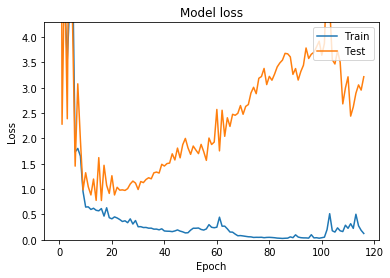

Prediction:


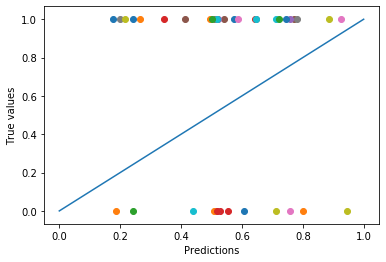

Error histogram:


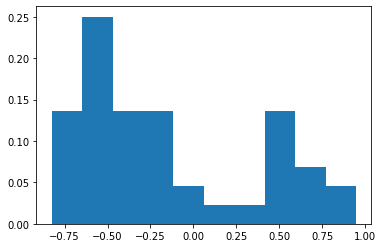

Confusion matrix (same row = same True values):
Labels =  [0, 1]
Prediction :	0 	1 	
	Real :			Total
	 0 	0.27 	0.30 	13
	 1 	0.73 	0.70 	31
	Total:	11	33	44
Confusion matrix (same row = same True values):
Score Kappa : -0.02857142857142847
Score F1 : 0.5909090909090909
Saving model...Finished!


In [19]:
test(class_nb=2, epochs=500, pca=True, nb_pca=7, 
     freq=1000, last_second=5, index=index,# Hyperparametre : nb de classe, nb de pca, freq de données
     smoothing_freq_max=300, down_freq_max=6,
     conv_channel=10, conv_windows=5, # The number of cells for the last layers before Dense(2)
     step_smoothing=10, step_down=1,
     # Variables pour smoothing/down_sampling:
     window_ori=50, channels_ori=5, pool_ori=10,
     window_sm=50, channels_sm=5, pool_sm=10,
     window_dn=50, channels_dn=5, pool_dn=10,
     nb_dense=50)